In [13]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import cv2
from scipy import ndimage

In [14]:
def random_shift(img, shift, angle):
    """Translate image in x direction randomly"""
    x_shift = np.random.uniform(-shift, shift)
    # y_shift = np.random.uniform(-shift, shift)
    new_angle = angle + (-x_shift * 0.004)  # 0.004 angle change for every pixel shifted

    return ndimage.shift(img, (0, x_shift, 0)), new_angle


def random_brightness(image):
    """Apply random brightness on HSV formatted image"""
    # new_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    new_img = np.array(image)
    random_bright = .5 + np.random.uniform()
    new_img[:, :, 2] = new_img[:, :, 2] * random_bright
    new_img[:, :, 2][new_img[:, :, 2] > 255] = 255
    new_img = np.array(new_img)

    # new_img = cv2.cvtColor(new_img, cv2.COLOR_HSV2RGB)

    return new_img


def random_saturation(image):
    """Apply random saturation on HSV formatted image"""
    saturation_threshold = 0.4 + 1.2 * np.random.uniform()
    new_img = np.array(image)
    # new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2HSV)
    new_img[:, :, 1] = new_img[:, :, 1] * saturation_threshold
    new_img = np.array(new_img)
    # new_img = cv2.cvtColor(new_img, cv2.COLOR_HSV2RGB)
    return new_img


def random_shadow(image):
    top_y = image.shape[1] * np.random.uniform()
    top_x = 0
    bot_x = image.shape[0]
    bot_y = image.shape[1] * np.random.uniform()
    # image_hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    image_hls = image
    shadow_mask = 0 * image_hls[:, :, 1]
    X_m = np.mgrid[0:image.shape[0], 0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0], 0:image.shape[1]][1]
    shadow_mask[((X_m - top_x) * (bot_y - top_y) - (bot_x - top_x) * (Y_m - top_y) >= 0)] = 1
    if np.random.randint(2) == 1:
        random_bright = .5
        cond1 = shadow_mask == 1
        cond0 = shadow_mask == 0
        if np.random.randint(2) == 1:
            image_hls[:, :, 1][cond1] = image_hls[:, :, 1][cond1] * random_bright
        else:
            image_hls[:, :, 1][cond0] = image_hls[:, :, 1][cond0] * random_bright
    # new_img = cv2.cvtColor(image_hls, cv2.COLOR_HLS2RGB)
    new_img = image_hls
    
    return new_img


def random_lightness(image):
    lightness_threshold = 0.2 + 1.4 * np.random.uniform()
    new_img = np.array(image)
    # new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2HLS)
    new_img[:, :, 1] = new_img[:, :, 1] * lightness_threshold
    # new_img = cv2.cvtColor(image, cv2.COLOR_HLS2RGB)

    return new_img


def preprocess_img(image, angle):
    """Preprocess the image"""
    
    new_angle = angle

    # Crop image, 65 pixels from top and 25 from bottom
    new_img = image[65:135, :, :]
    
    new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
    
    # Resize image to 64 width and 64 height
    new_img = cv2.resize(new_img, (64, 64), interpolation=cv2.INTER_AREA)

    if flip_a_coin():
        # Apply blurring 
        new_img = cv2.GaussianBlur(new_img, (3, 3), 0)

    new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2HSV)
    if flip_a_coin():
        # Apply random brightness 
        new_img = random_brightness(new_img)

    if flip_a_coin():
        # Apply random saturation
        new_img = random_saturation(new_img)
    new_img = cv2.cvtColor(new_img, cv2.COLOR_HSV2RGB)

    new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2HLS)
    if flip_a_coin():
        # Apply random lightness 
        new_img = random_lightness(new_img)
        
    if flip_a_coin():
        # Apply random shadow
        new_img = random_shadow(new_img)
    new_img = cv2.cvtColor(new_img, cv2.COLOR_HLS2RGB)    
    
    if flip_a_coin():
        # Apply random translation in the x-axis and get new image and new angle
        new_img, new_angle = random_shift(new_img, 25, angle)
        
    if flip_a_coin():
        # Flip image and steering angle
        new_img = np.fliplr(new_img)
        new_angle = -new_angle
        
    return new_img, new_angle


def flip_a_coin():
    return np.random.uniform() <= .5


def transform_images_in_line(line, write_path, read_path):
    img_center_path = read_path + line[0].split('/')[-1]
    img_left_path = read_path + line[1].split('/')[-1]
    img_right_path = read_path + line[2].split('/')[-1]

    steering_angle = line[3]
    throttle = line[4]

    aug_lines = []
    # create 5 images with random brightness for each of the center, left, and right image
    for i in range(10):
        c_img = preprocess_img(cv2.imread(img_center_path))
        c_img_path = write_path + line[0].split('/')[-1].split('.')[0] + "_{}".format(i) + ".jpg"
        cv2.imwrite(c_img_path, c_img)
        l_img = preprocess_img(cv2.imread(img_left_path))
        l_img_path = write_path + line[1].split('/')[-1].split('.')[0] + "_{}".format(i) + ".jpg"
        cv2.imwrite(l_img_path, l_img)
        r_img = preprocess_img(cv2.imread(img_right_path))
        r_img_path = write_path + line[2].split('/')[-1].split('.')[0] + "_{}".format(i) + ".jpg"
        cv2.imwrite(r_img_path, r_img)

        aug_lines.append([c_img_path, l_img_path, r_img_path, steering_angle, throttle])

    return aug_lines

Recorded angles list size: 20937
We have 7176 different angles in the data set
The bins
[-1.   -0.96 -0.92 -0.88 -0.84 -0.8  -0.76 -0.72 -0.68 -0.64 -0.6  -0.56
 -0.52 -0.48 -0.44 -0.4  -0.36 -0.32 -0.28 -0.24 -0.2  -0.16 -0.12 -0.08
 -0.04  0.    0.04  0.08  0.12  0.16  0.2   0.24  0.28  0.32  0.36  0.4
  0.44  0.48  0.52  0.56  0.6   0.64  0.68  0.72  0.76  0.8   0.84  0.88
  0.92  0.96  1.  ]
The Count
[  40   27   35   49   57   88   92   69   79   87  120  166  180  224  245
  341  398  475  425  512  411  758  592 1052 1398 5907  997  845  630  893
  513  512  602  413  412  285  270  238  108  104   57   28   24   27   17
   28    9    6   12   80]
Average number of angles per bin for 50 bins is 419.0


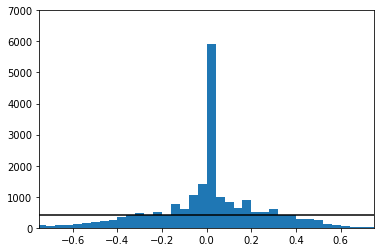

Done preprocessing data.


In [27]:
samples = []
aug_imgs_dir_path = "../fifthSimData/preprocessed_imgs/"
read_path = "../fifthSimData/IMG/"
with open('../Datasets/firstAndSecondTrack/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)

    # ignoring the first line (header)
    next(reader, None)

    for line in reader:
        samples.append(line)

recorded_angles = []
for sample in samples:
    recorded_angles.append(float(sample[3]))

print("Recorded angles list size: {}".format(len(recorded_angles)))

angles, counts = np.unique(recorded_angles, return_counts=True)

print("We have {} different angles in the data set".format(len(counts)))

num_bins = 50
avg_angles_per_bin = np.ceil(len(recorded_angles) / num_bins)
hist, bins = np.histogram(recorded_angles, num_bins)

print("The bins")
print(np.round(bins, 4))

print("The Count")
print(hist)

print('Average number of angles per bin for {} bins is {}'.format(num_bins, avg_angles_per_bin))

% matplotlib inline

plt.hist(recorded_angles, bins=num_bins)
plt.axis([-0.75,0.75,0,7000])
plt.plot((np.min(recorded_angles), np.max(recorded_angles)), (avg_angles_per_bin, avg_angles_per_bin), 'k-')
plt.show()

# angle_dict = {}
# with open('../fifthSimData/driving_log.csv', mode='r') as csvfile, \
#         open('../fifthSimData/balanced_driving_log.csv', mode='w') as new_csv_file:
#     reader = csv.reader(csvfile)
#     writer = csv.writer(new_csv_file, delimiter=',')
# 
#     # ignoring the first line (header)
#     next(reader, None)
# 
#     for line in reader: 
#         angle = float(line[3])
#         
#         for b in range(num_bins):
#             bin_center = round(float((bins[b]+bins[b+1])/2), 4)
#             # print(bin_center)
#             if bins[b] <= angle < bins[b+1]:
#                 if bin_center in angle_dict:
#                     count = angle_dict[bin_center]
#                     # print(count)
#                     # if count <= avg_angles_per_bin:
#                     aug_lines = transform_images_in_line(line, write_path=aug_imgs_dir_path, read_path=read_path)
#                     # aug_lines = [line]
#                     for l in aug_lines:
#                         writer.writerow(l)
#                     angle_dict[bin_center] = count + 1
#                 else:
#                     aug_lines = transform_images_in_line(line, write_path=aug_imgs_dir_path, read_path=read_path)
#                     # aug_lines = [line]
#                     for l in aug_lines:
#                         writer.writerow(l)
#                     angle_dict[bin_center] = 1
# 
# print(angle_dict)




print("Done preprocessing data.")

26895


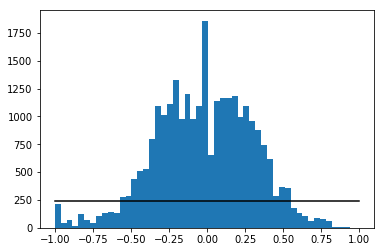

In [9]:
samples = []

% matplotlib inline

# angle_dict = {}
angles_processed = []

with open('../fourthSimData/balanced_driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)

    for line in reader: 
        angle = float(line[3])
        angles_processed.append(angle)
        # for b in range(num_bins):
        #     bin_center = round(float((bins[b]+bins[b+1])/2), 4)
        #     # print(bin_center)
        #     if bins[b] <= angle < bins[b+1]:
        #         if bin_center in angle_dict:
        #             count = angle_dict[bin_center]
        #             angle_dict[bin_center] = count + 1
        #         else:
        #             angle_dict[bin_center] = 1
          
        
# x_values = list(angle_dict.keys())
# # print(x_values)
y_values = list(angle_dict.keys()).sort()
# width = 0.9 * (bins[1] - bins[0])
# plt.bar(x_values, y_values, align='center', width=width)
plt.hist(angles_processed, bins=num_bins)
plt.plot((np.min(recorded_angles), np.max(recorded_angles)), (avg_angles_per_bin, avg_angles_per_bin), 'k-')
print(len(angles_processed))
plt.show()

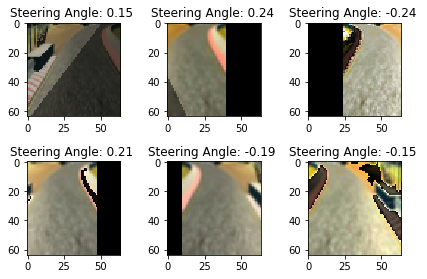

In [26]:
import matplotlib.pyplot as plt
% matplotlib inline

image = cv2.imread('../Datasets/data/IMG/center_2016_12_01_13_31_14_398.jpg')
plt.imshow(image)

for i in range(6):
    new_img, new_angle = preprocess_img(image, -0.15)
    plt.subplot(2, 3, i+1)
    plt.imshow(new_img)
    plt.title("Steering Angle: {:.2f} ".format(new_angle))
    
plt.tight_layout()
plt.show()
